In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# 21. Label Trick GNN Training

Here, I train a basic GNN with node features, including target information for a set of "fixed" features which are not evaluated in training flows.  Cases used for training and validation have the labor feature zeroed out.  

Batching is used for training, and nodes are sampled at each layer.  I use a 2-layer GNN

*This script takes about 2 hours on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np

In [3]:
from pathlib import Path
import importlib
import pickle

In [4]:
import stellargraph as sg
from stellargraph.layer import HinSAGE
from stellargraph.mapper import HinSAGENodeGenerator

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import keras
import tensorflow.keras.metrics as km
from keras import initializers
import tensorflow as tf

2023-12-28 20:39:32.810915: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-28 20:39:32.810942: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-28 20:39:32.810950: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-28 20:39:32.810989: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-28 20:39:32.811008: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Import Data
Import Stellargraph dataset for training

##### Heterogeneous graph

In [5]:
# Training and validation clients - monitor training on val clients
with open(Path(setup.temp_path).joinpath('20_DATA_stellargraph_train_val.pkl'), 'rb') as fin:
      sba_graph  = pickle.load(fin)

In [6]:
print(sba_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 634346, Edges: 11132277

 Node types:
  LoanNr_ChkDgt: [633035]
    Features: float32 vector, length 11
    Edge types: LoanNr_ChkDgt-loan_naics->NAICS, LoanNr_ChkDgt-loan_sector_naics->NAICS
  NAICS: [1311]
    Features: float32 vector, length 9
    Edge types: NAICS-loan_naics->LoanNr_ChkDgt, NAICS-loan_sector_naics->LoanNr_ChkDgt

 Edge types:
    LoanNr_ChkDgt-loan_sector_naics->NAICS: [10499242]
        Weights: all 1 (default)
        Features: none
    LoanNr_ChkDgt-loan_naics->NAICS: [633035]
        Weights: all 1 (default)
        Features: none


##### Labels

In [7]:
label_data = pd.read_parquet(Path(setup.temp_path).joinpath('11_DATA_labels_train_val.parquet'))

## Process labels
Get separate train, test label dataframes.  Also get initial target rate (for metric tracking)

In [8]:
train_labels = label_data[(label_data['dset'] == 'train') & (label_data['train_fix'] == 0)] \
    .drop(columns=['dset']).set_index('LoanNr_ChkDgt')
val_labels = label_data[label_data['dset'] == 'val'].drop(columns=['dset']).set_index('LoanNr_ChkDgt')
print(f'this graph labels shape {label_data.shape}')
print(f'train labels shape {train_labels.shape}')
print(f'validation labels shape {val_labels.shape}')

this graph labels shape (633035, 4)
train labels shape (123855, 2)
validation labels shape (220187, 2)


In [9]:
vc = train_labels['target'].value_counts(normalize=True)
base_thresh = vc.loc[1]
print(f'target rate: {base_thresh}')

target rate: 0.2030115861289411


## Train

##### Set seeds to setup

In [10]:
# Set some seeds
np.random.seed(16)
tf.random.set_seed(16)
sg.random.set_seed(4345)

##### Node Predictor Generator and "Flows"
Create objects to train on train cases, monitor on validation cases

In [11]:
generator = HinSAGENodeGenerator(sba_graph, batch_size=setup.gnn_batch_size, 
                                 num_samples=setup.gnn_num_samples,
                                 head_node_type='LoanNr_ChkDgt',
                                 seed=2454)

In [12]:
train_gen = generator.flow(train_labels.index, train_labels['target'], shuffle=True)

In [13]:
val_gen = generator.flow(val_labels.index, val_labels['target'], shuffle=False)

##### Create HinSage model (a Keras model)

In [14]:
graphsage_model = HinSAGE(
    layer_sizes=setup.gnn_layer_sizes, 
    generator=generator, bias=True, dropout=setup.gnn_dropout
)

In [15]:
tf.random.set_seed(16)
keras.utils.set_random_seed(5653)
sg.random.set_seed(34)

In [16]:
x_inp, x_out = graphsage_model.in_out_tensors()

prediction = layers.Dense(units=1, activation="sigmoid",
                         kernel_initializer=initializers.glorot_uniform(seed=2343),
                         bias_initializer = initializers.Zeros())(x_out) 

/Users/valeriecarey/miniconda3/envs/tf_p38/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [17]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=setup.gnn_learning_rate),
    loss = losses.binary_crossentropy,  
    metrics=[km.AUC(curve='PR'), km.AUC(curve='ROC'), km.Precision(thresholds=base_thresh), 
             km.Recall(thresholds=base_thresh)],
)

##### Fit model

In [18]:
history = model.fit(
    train_gen, epochs=20, validation_data=val_gen, verbose=2, shuffle=False
)

Epoch 1/20


2023-12-28 20:39:54.952546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-28 20:41:12.676068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3871/3871 - 175s - loss: 0.4877 - auc: 0.2753 - auc_1: 0.6258 - precision: 0.2601 - recall: 0.6547 - val_loss: 0.4739 - val_auc: 0.3248 - val_auc_1: 0.6824 - val_precision: 0.2658 - val_recall: 0.8453 - 175s/epoch - 45ms/step
Epoch 2/20
3871/3871 - 172s - loss: 0.4801 - auc: 0.2972 - auc_1: 0.6533 - precision: 0.2761 - recall: 0.6810 - val_loss: 0.4725 - val_auc: 0.3321 - val_auc_1: 0.6865 - val_precision: 0.2730 - val_recall: 0.8221 - 172s/epoch - 44ms/step
Epoch 3/20
3871/3871 - 174s - loss: 0.4788 - auc: 0.3013 - auc_1: 0.6575 - precision: 0.2790 - recall: 0.6918 - val_loss: 0.4720 - val_auc: 0.3287 - val_auc_1: 0.6835 - val_precision: 0.2767 - val_recall: 0.7916 - 174s/epoch - 45ms/step
Epoch 4/20
3871/3871 - 1165s - loss: 0.4779 - auc: 0.3012 - auc_1: 0.6585 - precision: 0.2784 - recall: 0.6989 - val_loss: 0.4774 - val_auc: 0.3284 - val_auc_1: 0.6815 - val_precision: 0.2628 - val_recall: 0.8532 - 1165s/epoch - 301ms/step
Epoch 5/20
3871/3871 - 1070s - loss: 0.4776 - auc: 0.3004 - 

In [19]:
# Tensorflow save format to work around issue 
# https://github.com/tensorflow/tensorflow/issues/46659
model.save(Path(setup.temp_path).joinpath('21_DATA_model.keras'), save_format='tf')

## Training Curves

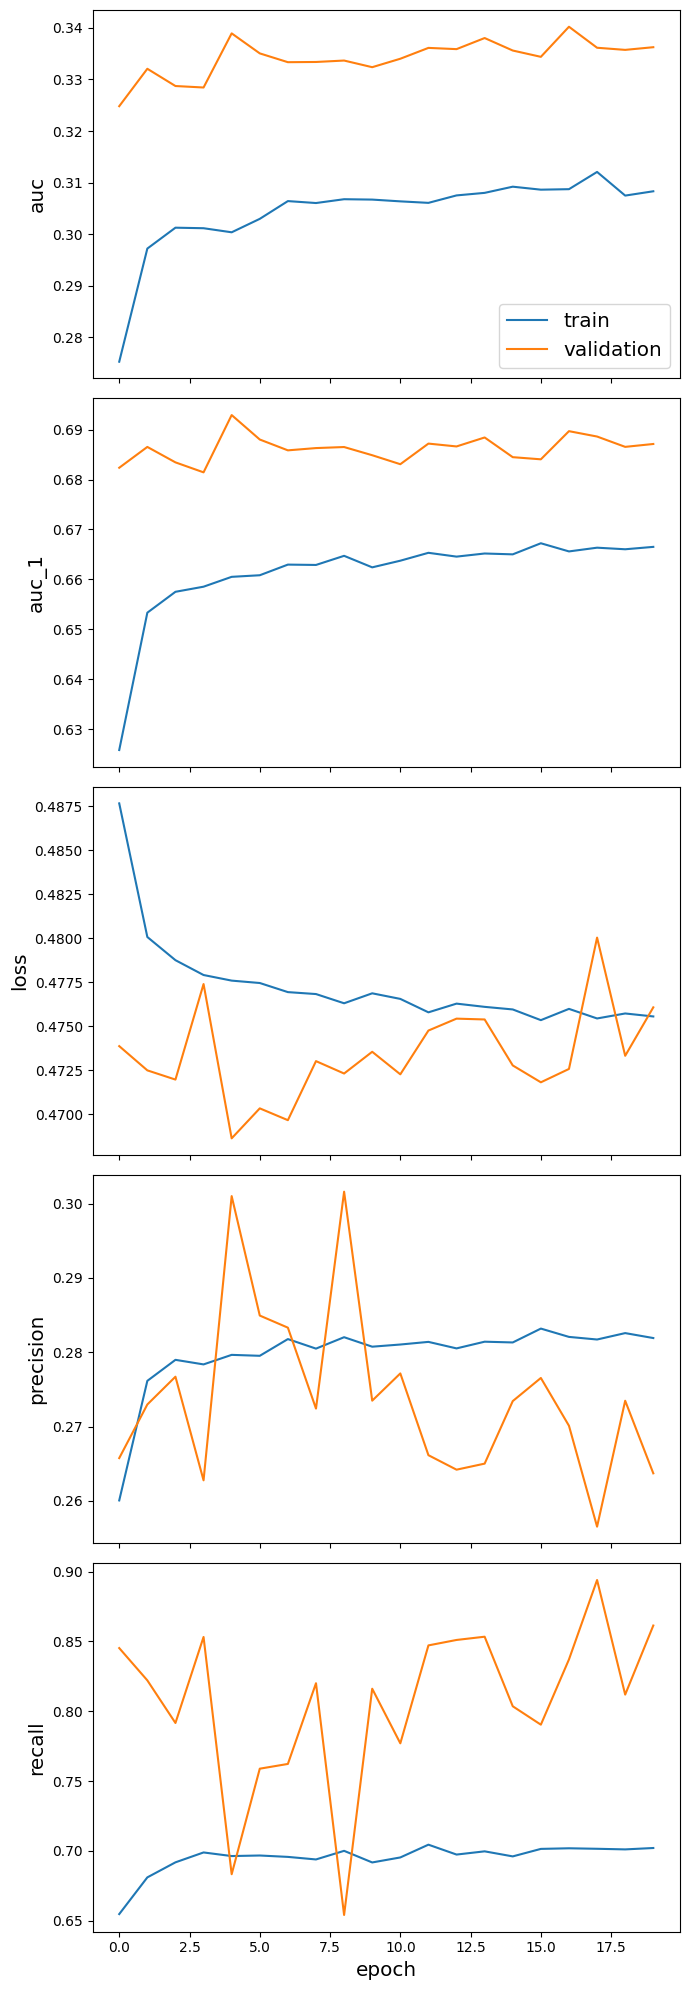

In [20]:
sg.utils.plot_history(history)

In [21]:
pd.DataFrame(history.history).to_csv(Path(setup.temp_path).joinpath('21_REPORT_fit_progress.csv'))

## Metrics

In [22]:
val_metrics = model.evaluate(val_gen)

6881/6881 [==============================] - 103s 15ms/step - loss: 0.4762 - auc: 0.3353 - auc_1: 0.6871 - precision: 0.2632 - recall: 0.8608


In [23]:
train_metrics = model.evaluate(train_gen)

3871/3871 [==============================] - 59s 15ms/step - loss: 0.4782 - auc: 0.3238 - auc_1: 0.6795 - precision: 0.2624 - recall: 0.8567


In [24]:
metrics = pd.concat([pd.DataFrame(dict(zip(model.metrics_names, [[t] for t in val_metrics]))),
                         pd.DataFrame(dict(zip(model.metrics_names, [[t] for t in train_metrics])))],
                        keys=['val', 'train'])
metrics.to_csv(Path(setup.temp_path).joinpath('21_REPORT_train_metrics.csv'), index=True)
metrics

,,loss,auc,auc_1,precision,recall
val,0,0.476156,0.335328,0.687056,0.263237,0.860828
train,0,0.478202,0.323791,0.679511,0.262432,0.856745
